In [1]:
import numpy as np
#%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [2]:
# Load dataset, split into test and training data
train_ds, test_ds = tfds.load('cifar10', split= ['train', 'test'], data_dir="data\\", as_supervised=True)

Shuffling and writing examples to data/cifar10/3.0.2.incompleteHCFC52/cifar10-train.tfrecord


Shuffling and writing examples to data/cifar10/3.0.2.incompleteHCFC52/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to data\cifar10\3.0.2. Subsequent calls will reuse this data.


In [3]:
def overview_data():
  train_ds_numpy = tfds.as_numpy(train_ds)
  test_ds_numpy = tfds.as_numpy(test_ds)

  #Look at shapes images and labels of dataset
  print(len(train_ds))
  print(len(test_ds))

  x = 0
  for i in train_ds_numpy:
    x += 1
    print(format(i[0].shape))
    print(np.amax(i[0]))
    print(np.amin(i[0]))
    print(format(i[1]))
    if x== 5:
      break

  x = 0
  for i in test_ds_numpy:
    x += 1
    print(format(i[0].shape))
    print(np.amax(i[0]))
    print(np.amin(i[0]))
    print(format(i[1]))
    if x== 5:
      break

In [4]:
def plot_data():
  train_ds_numpy = tfds.as_numpy(train_ds)
  test_ds_numpy = tfds.as_numpy(test_ds)

  # Plot 5 samples with their corresponding label.
  fig, ax = plt.subplots(1,5)
  x = 0
  for j in train_ds_numpy:
    
    # Readout an image and the corresponding label.
    img = j[0]

    label = {
        0 : 'airplane',
        1 : 'automobile',
        2 : 'bird',
        3 : 'cat',
        4 : 'deer',
        5 : 'dog',
        6 : 'frog',
        7 : 'horse',
        8 : 'ship',
        9 : 'truck'
    }
    # if label is still just an integer
    if isinstance(j[1], np.int64)  :
      lbl = label[j[1]]
    # if label is already an one-hot vektor
    else:
      indice = np.where(j[1] == 1)
      indice = indice[0]
      lbl = label[int(indice)]

    ax[x].imshow(img)
    ax[x].set_title(lbl)
    ax[x].axis("off")

    x += 1

    if x==5:
      break

50000
10000
(32, 32, 3)
249
0
7
(32, 32, 3)
249
5
8
(32, 32, 3)
172
54
4
(32, 32, 3)
247
10
4
(32, 32, 3)
209
8
6
(32, 32, 3)
255
5
7
(32, 32, 3)
255
0
0
(32, 32, 3)
225
6
6
(32, 32, 3)
255
58
9
(32, 32, 3)
246
0
5


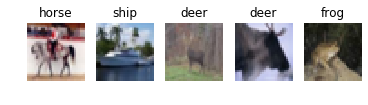

In [5]:
overview_data()
plot_data()

Resnet

In [ ]:
class ResidualBlock():

    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(filters = 90,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (32, 32, 3))
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_1 = tf.keras.activations.relu

        self.conv_2 = tf.keras.layers.Conv2D(filters = 90,
                                         kernel_size = 3,
                                         activation = None,
                                         padding = 'same',
                                         kernel_initializer = tf.keras.initializers.glorot_normal,   # (1)
                                         bias_initializer = 'zeros',                                 # (2)
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),        # (3)
                                         input_shape = (32, 32, 3))
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                         # (4)
        self.activ_2 = tf.keras.activations.relu


DenseNet